# Setup

In [160]:
# Standard Imports
import os
import numpy as np
from datetime import datetime, timedelta
import itertools as it
import pandas as pd
import pandas_datareader as pdr
from pandas import IndexSlice
from dateutil.relativedelta import relativedelta
import plotly.express as px
import plotly.graph_objects as go
from collections.abc import Iterable
from tabulate import tabulate
import utils

In [161]:
# Third Party Imports - CSV files stored locally so do not need this afterwards
from iexfinance import stocks
from iexfinance.refdata import get_symbols

In [162]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
# Globals
idx = IndexSlice
RANDOM_SEED = utils.RANDOM_SEED
SKLEARN_RANDOM_SEED = utils.SKLEARN_RANDOM_SEED
PRICE = utils.PRICE
RETURN = utils.RETURN
TARGET_COL = utils.TARGET_COL

DATA_DIR = os.path.join(os.getcwd(), "data")
os.makedirs(DATA_DIR, exist_ok=True)
IMAGES_DIR = os.path.join(os.getcwd(), "images")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)

In [17]:
def get_symbol_list():
    _avail_symbols = get_symbols()

    # Convert to dataframe and set index to "symbol" / ticker
    df_symbols = pd.DataFrame(_avail_symbols).set_index("symbol")
    
    df_companies = df_symbols[
    df_symbols.name.str.contains("Momenta Pharmaceuticals") |
    df_symbols.name.str.contains("Zoetis")
    ]

    df_companies
    symbol_list = df_companies.index.to_list()
    return symbol_list

# Data Retrivial

## Obtain Ticker(s) and Fama-French Dataset Name

In [62]:
# List of dicts for each of the stocks available through IEX api
_avail_symbols = get_symbols()

# Convert to dataframe and set index to "symbol" / ticker
df_symbols = pd.DataFrame(_avail_symbols).set_index("symbol")
df_symbols.head(5)

,exchange,name,date,type,iexId,region,currency,isEnabled,figi,cik
symbol,,,,,,,,,,
A,NYS,Agilent Technologies Inc.,2020-05-18,cs,IEX_46574843354B2D52,US,USD,True,BBG000C2V3D6,1090872
AA,NYS,Alcoa Corp.,2020-05-18,cs,IEX_4238333734532D52,US,USD,True,BBG00B3T3HD3,1675149
AAAU,PSE,Perth Mint Physical Gold ETF,2020-05-18,et,IEX_474B433136332D52,US,USD,True,BBG00LPXX872,None
AACG,NAS,ATA Creativity Global Sponsored ADR,2020-05-18,ad,IEX_44595A4C53392D52,US,USD,True,BBG000V2S3P6,None
AADR,PSE,AdvisorShares Dorsey Wright ADR ETF,2020-05-18,et,IEX_5253355435362D52,US,USD,True,BBG000BDYRW6,None


Check for companies you want to retrieve data for and their ticker/symbol
+ Momenta Pharmaceuticals
+ Zoetis

In [63]:
df_companies = df_symbols[
    df_symbols.name.str.contains("Momenta Pharmaceuticals") |
    df_symbols.name.str.contains("Zoetis")
]

df_companies

,exchange,name,date,type,iexId,region,currency,isEnabled,figi,cik
symbol,,,,,,,,,,
MNTA,NAS,Momenta Pharmaceuticals Inc.,2020-05-18,cs,IEX_4B32364D544B2D52,US,USD,True,BBG000M5QDX0,1235010
ZTS,NYS,Zoetis Inc. Class A,2020-05-18,cs,IEX_5457364B4B562D52,US,USD,True,BBG0039320N9,1555280


Retrieve Symbol(s)

In [64]:
symbol_list = df_companies.index.to_list()
symbol_list

['MNTA', 'ZTS']

Fama-French Availale Data

In [65]:
ff_avail_data = pdr.famafrench.get_available_datasets()

In [67]:
list((s for s in ff_avail_data if "f-f" in s.lower()))

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'F-F_Momentum_Factor',
 'F-F_Momentum_Factor_daily',
 'F-F_ST_Reversal_Factor',
 'F-F_ST_Reversal_Factor_daily',
 'F-F_LT_Reversal_Factor',
 'F-F_LT_Reversal_Factor_daily']

## Download data
+ **force_api_call**: if True does not read local csv file and uses IEX api call to retrieve data: Data stored in \data\symbol_raw_data.csv
+ **ff_dataset_name**: Fama French dataset to download using pandas_datareader.

In [74]:
# User Settings
force_api_call = True
ff_dataset_name = "F-F_Research_Data_5_Factors_2x3_daily"

end = datetime(2020, 5, 12)
n_years = 5

start = end - relativedelta(end, years=n_years)

end, start

(datetime.datetime(2020, 5, 12, 0, 0), datetime.datetime(2015, 5, 12, 0, 0))

### Retrieve Fama-French Data

In [75]:
#Loading Factor Data
_tmp_local_fpath = os.path.join(DATA_DIR, f"{ff_dataset_name}_raw_data.csv".lower())

if not os.path.exists(_tmp_local_fpath) or force_api_call:
    
    _tmp_df_ff = pdr.data.DataReader(ff_dataset_name, start=start, end=end, data_source="famafrench")[0].iloc[:, idx[:5]]
    _tmp_df_ff.index = pd.to_datetime(_tmp_df_ff.index, format="%Y%m%d", utc=False)
                                     
    print(f"\nLocal csv filepath to write {ff_dataset_name} raw data to,\n\n>> {_tmp_local_fpath}\n")
    _tmp_df_ff.to_csv(_tmp_local_fpath)
    
else:
    print(f"Reading in data from,\n\n>> {_tmp_local_fpath}\n")
    _tmp_df_ff = pd.read_csv(_tmp_local_fpath, index_col=0)

# Store columns from Fama-French Dataset
cols_ff = list(_tmp_df_ff.columns)

with pd.option_context("max_rows", 5):
    display(_tmp_df_ff)


Local csv filepath to write F-F_Research_Data_5_Factors_2x3_daily raw data to,

>> /home/jovyan/work/cqf/cqf_exams/exam_3/data/f-f_research_data_5_factors_2x3_daily_raw_data.csv



,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2015-05-12,-0.27,0.00,0.07,-0.15,-0.01
2015-05-13,0.01,0.00,0.02,-0.07,0.03
...,...,...,...,...,...
2020-03-30,3.16,-0.82,-2.18,-0.17,0.18
2020-03-31,-1.44,1.51,-0.43,0.39,-0.13


### Retrieve Asset(s) Data

Gather raw (uncleaned and augmented data) for the assets within the `symbol_list` and store in a dict.
```python
df_raw_dict = {
    symbol : DataFrame
}
```

In [76]:
# Dict to hold dataframe for each symbol
df_raw_dict = dict()
# df_raw_list = []  # TODO: is this still required?

# This is the column name for the closing price

for symbol in symbol_list:
    
    # filepath to store data
    local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_raw_data.csv".lower())
    
    # keyword arguments called to api call
    kwargs = {
        "symbols":symbol, 
        "output_format":"pandas",
        "end":end,
        "start":start
    }
    
    # Retrieve data
    if not os.path.exists(local_fpath) or force_api_call:
        
        print(f"Using api call with kwargs: {kwargs}")
        _tmp_df = stocks.get_historical_data(**kwargs)[[PRICE]]
        
        print(f"\nLocal csv filepath to write raw data to,\n\n>> {local_fpath}\n")
        _tmp_df.to_csv(local_fpath)
    
    else:
        
        print(f"Reading in data from,\n\n>> {local_fpath}\n")
        _tmp_df = pd.read_csv(local_fpath, index_col=0)
    
    # Join Fama-French Data
    _tmp_df = _tmp_df.join(_tmp_df_ff)
    
    # df_raw_list.append(df_tmp)    # TODO: is this still required? or prefer using dict going foward?
    df_raw_dict[symbol] = _tmp_df

Using api call with kwargs: {'symbols': 'MNTA', 'output_format': 'pandas', 'end': datetime.datetime(2020, 5, 12, 0, 0), 'start': datetime.datetime(2015, 5, 12, 0, 0)}

Local csv filepath to write raw data to,

>> /home/jovyan/work/cqf/cqf_exams/exam_3/data/mnta_raw_data.csv

Using api call with kwargs: {'symbols': 'ZTS', 'output_format': 'pandas', 'end': datetime.datetime(2020, 5, 12, 0, 0), 'start': datetime.datetime(2015, 5, 12, 0, 0)}

Local csv filepath to write raw data to,

>> /home/jovyan/work/cqf/cqf_exams/exam_3/data/zts_raw_data.csv



In [11]:
df_raw_dict;

### Remove NaN values

In [12]:
df_clean_dict = dict()

with pd.option_context("max_rows", 5):
    for symbol, df in df_raw_dict.items():
        
        df_clean_dict[symbol] = df.fillna(axis=0, method="ffill")
        
        print("-"*50, "\n", symbol)
        
        display(df_clean_dict[symbol])
        
    print("-"*50)

-------------------------------------------------- 
 MNTA


,close,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,
2015-05-18,20.22,0.44,0.73,-0.09,-0.17,-0.28
2015-05-19,19.31,-0.09,-0.07,0.23,-0.09,-0.04
...,...,...,...,...,...,...
2020-05-11,34.30,-1.44,1.51,-0.43,0.39,-0.13
2020-05-12,31.85,-1.44,1.51,-0.43,0.39,-0.13


-------------------------------------------------- 
 ZTS


,close,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,
2015-05-18,46.73,0.44,0.73,-0.09,-0.17,-0.28
2015-05-19,47.45,-0.09,-0.07,0.23,-0.09,-0.04
...,...,...,...,...,...,...
2020-05-11,126.39,-1.44,1.51,-0.43,0.39,-0.13
2020-05-12,124.01,-1.44,1.51,-0.43,0.39,-0.13


--------------------------------------------------


Write / Load Cleaned Data

### Save Clean Data to CSV

In [16]:
for symbol, df in df_clean_dict.items():
    # filepath to store data
    local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_clean_data.csv".lower())
    print(f"\nLocal csv filepath to write cleaned data to,\n\n>> {local_fpath}\n")
    df.to_csv(local_fpath)


Local csv filepath to write cleaned data to,

>> /home/jovyan/work/cqf/cqf_exams/exam_3/data/mnta_clean_data.csv


Local csv filepath to write cleaned data to,

>> /home/jovyan/work/cqf/cqf_exams/exam_3/data/zts_clean_data.csv



### Read Clean Data from CSV
Ensure `symbol_list` has been defined

In [18]:
_df_tmp_dict = dict()

symbol_list = get_symbol_list()

try:
    
    for symbol in symbol_list:
        
        local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_clean_data.csv".lower())
        
        print(f"Reading in data from,\n\n>> {local_fpath}\n")
        
        _df_tmp = pd.read_csv(local_fpath, index_col=0)
        
        _df_tmp_dict[symbol] = _df_tmp
        
except IOError as e:
    print(e)
else:
    print("Data succesfully read in.\n")
    df_clean_dict = _df_tmp_dict

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\mnta_clean_data.csv

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\zts_clean_data.csv

Data succesfully read in.



In [19]:
df_clean_dict[symbol_list[0]].head(1)

,close,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,
2015-05-18,20.22,0.44,0.73,-0.09,-0.17,-0.28


# Feature Engineering

Add returned data for 1D - N_Days (end inclusive) and store *copied* dataframe in new dict.
```python
df_returns_dict = {
    symbol : DataFrame 
}
```
with columns
<br><br>
["Mkt-RF", "SMB","HML", "RMW", "CMA, "return", "return_sign", "ret_2", "ret_2_sign",..., "ret_N", "ret_N_sign", "mom_1", ..., "mom_N"]
<br><br>
**WARNING**: for np.sign(X) if x == 0, then sign ==0. Thus 3 possible returns from np.sign are [-1, if x<0, 0 if x==0, 1 if x>0]. Not a binomial output.

In [20]:
aug_data = utils.feature_engineering(df_clean_dict)

In [22]:
df_aug_dict = aug_data["df_dict"]

In [23]:
np.isnan(df_aug_dict[symbol_list[0]]).apply("sum", axis=0).sum()

0

There should be no NaN values in above out. If there is then remove "sum" and identify column with NaN values.

In [25]:
df_aug_dict[symbol_list[0]].head(5).T

date,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22
Mkt-RF,0.570000,0.160000,0.990000,-0.430000,0.630000
SMB,0.100000,-0.310000,0.160000,0.520000,0.090000
HML,0.000000,-0.630000,-0.430000,-0.200000,-0.060000
RMW,0.140000,0.150000,-0.130000,0.070000,-0.160000
CMA,-0.070000,-0.090000,-0.160000,-0.050000,-0.240000
return,-0.003529,0.010987,0.065139,-0.026558,0.020808
return_t-1,0.028133,-0.003529,0.010987,0.065139,-0.026558
return_t-2,-0.015281,0.028133,-0.003529,0.010987,0.065139
return_t-3,0.006264,-0.015281,0.028133,-0.003529,0.010987
return_t-4,0.004498,0.006264,-0.015281,0.028133,-0.003529


Do some further analysis of augmented features, especially target column "return_sign"

In [27]:
# Use a copied dataframe to do some further investigation with.
_tmp_df = df_aug_dict[symbol_list[0]].copy()

vc = lambda col: col.value_counts()
_tmp_df.select_dtypes(np.int).apply(vc, axis=0).sort_index(ascending=False)

,return_sign
1,611
0,41
-1,584


Replace signs of 0 with NaN and use forward fill to convert this to a binomial classification task

In [30]:
_tmp_df.loc[:, TARGET_COL] = (_tmp_df.loc[:, TARGET_COL]  # Select all columns that hold a return sign
                                .replace(0, np.nan)    # replace 0 with NaN value
                                .fillna(axis=0, method="ffill") # Use forward fill on NaN values
                               ).astype(np.int)
np.isnan(_tmp_df).apply("sum", axis=0).sum()

0

Implement above steps on dataframes in df_aug_dict

In [31]:
vc = lambda col: col.value_counts()

# Keep reference to a dataframe in dict
_tmp_df = df_aug_dict[symbol_list[1]]

print("Before")
display(_tmp_df.select_dtypes(np.int).apply(vc, axis=0).sort_index(ascending=False))

for symbol, df in df_aug_dict.items():
    df.loc[:, TARGET_COL] = (df[[TARGET_COL]]  # Select all columns that hold a return sign
                                .replace(0, np.nan)    # replace 0 with NaN value
                                .fillna(axis=0, method="ffill") # Use forward fill on NaN values
                               ).astype(np.int)

print("After")
display(_tmp_df.select_dtypes(np.int).apply(vc, axis=0).sort_index(ascending=False))

Before


,return_sign
1,658
0,14
-1,564


After


,return_sign
1,665
-1,571


In [32]:
np.isnan(_tmp_df).apply("sum", axis=0).sum()

0

### Save Augmented Features Dataset to CSV

In [33]:
for symbol, df in df_aug_dict.items():
    
    # filepath to store data
    local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_aug_data.csv".lower())
    
    print(f"\nLocal csv filepath to write augmented features dataset to,\n\n>> {local_fpath}\n")
    df.to_csv(local_fpath)


Local csv filepath to write augmented features dataset to,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\mnta_aug_data.csv


Local csv filepath to write augmented features dataset to,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\zts_aug_data.csv



### Read Augmented Features Dataset from CSV
Ensure `symbol_list` has been defined

In [484]:
_df_tmp_dict = dict()

try:
    
    for symbol in symbol_list:
        
        local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_aug_data.csv".lower())
        
        print(f"Reading in data from,\n\n>> {local_fpath}\n")
        
        _df_tmp = pd.read_csv(local_fpath, index_col=0)
        
        _df_tmp_dict[symbol] = _df_tmp
        
except IOError as e:
    print(e)
else:
    print("Data succesfully read in.\n")
    df_aug_dict = _df_tmp_dict

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\mnta_aug_data.csv

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\zts_aug_data.csv

Data succesfully read in.



In [485]:
df_aug_dict[symbol_list[0]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1236 entries, 2015-06-16 to 2020-05-12
Data columns (total 47 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Mkt-RF        1236 non-null   float64
 1   SMB           1236 non-null   float64
 2   HML           1236 non-null   float64
 3   RMW           1236 non-null   float64
 4   CMA           1236 non-null   float64
 5   return        1236 non-null   float64
 6   return_t-1    1236 non-null   float64
 7   return_t-2    1236 non-null   float64
 8   return_t-3    1236 non-null   float64
 9   return_t-4    1236 non-null   float64
 10  return_t-5    1236 non-null   float64
 11  return_t-6    1236 non-null   float64
 12  return_t-7    1236 non-null   float64
 13  return5D      1236 non-null   float64
 14  return5D_t-1  1236 non-null   float64
 15  return5D_t-2  1236 non-null   float64
 16  return5D_t-3  1236 non-null   float64
 17  return5D_t-4  1236 non-null   float64
 18  return5D_t-5  1236

## Time shift data
The data we have so far is "todays values" for each date and "known return for today + return sign" \
Hence we need to shift columns such that we have todays data and predicted tomorrow return sign. \
hence shift "return_sign" back by 1 day

In [486]:
df_aug_dict[symbol_list[0]].head(6)[df_aug_dict[symbol_list[0]].columns[::-1]]

,return_sign,STD21D,STD14D,STD7D,EWM21D,EWM14D,EWM7D,sma_21D,sma_14D,sma_7D,...,return_t-4,return_t-3,return_t-2,return_t-1,return,CMA,RMW,HML,SMB,Mkt-RF
date,,,,,,,,,,,,,,,,,,,,,
2015-06-16,-1,1.311968,1.028276,0.228962,21.592697,21.845006,22.280220,20.950000,21.638571,22.377143,...,0.004498,0.006264,-0.015281,0.028133,-0.003529,-0.07,0.14,0.00,0.10,0.57
2015-06-17,1,1.365289,0.822667,0.295627,21.726115,21.989195,22.430433,21.076667,21.895714,22.454286,...,0.006264,-0.015281,0.028133,-0.003529,0.010987,-0.09,0.15,-0.63,-0.31,0.16
2015-06-18,1,1.484816,0.854555,0.774206,22.001801,22.325827,22.928491,21.320000,22.222143,22.774286,...,-0.015281,0.028133,-0.003529,0.010987,0.065139,-0.16,-0.13,-0.43,0.16,0.99
2015-06-19,-1,1.501071,0.885795,0.820781,22.181722,22.526177,23.141582,21.533810,22.412143,22.988571,...,0.028133,-0.003529,0.010987,0.065139,-0.026558,-0.05,0.07,-0.20,0.52,-0.43
2015-06-22,1,1.524538,0.928779,0.902992,22.391871,22.766743,23.426401,21.770476,22.640000,23.254286,...,-0.003529,0.010987,0.065139,-0.026558,0.020808,-0.24,-0.16,-0.06,0.09,0.63
2015-06-23,1,1.569939,0.975004,0.837724,22.600080,23.002213,23.692451,21.990000,22.862143,23.598571,...,0.010987,0.065139,-0.026558,0.020808,0.008612,0.00,-0.08,0.27,0.24,0.12


In [487]:
df_completed_dict = dict()

for symbol, df in df_aug_dict.items():
    df_copy = df.copy()
    
    
    df_copy[return_sign] = df_copy[return_sign_col].shift(-1)
    
    df_completed_dict[symbol] = df_copy.dropna()

In [488]:
df_completed_dict[symbol_list[0]].head(5)[df_completed_dict[symbol_list[0]].columns[::-1]]

,return_sign,STD21D,STD14D,STD7D,EWM21D,EWM14D,EWM7D,sma_21D,sma_14D,sma_7D,...,return_t-4,return_t-3,return_t-2,return_t-1,return,CMA,RMW,HML,SMB,Mkt-RF
date,,,,,,,,,,,,,,,,,,,,,
2015-06-16,1.0,1.311968,1.028276,0.228962,21.592697,21.845006,22.280220,20.950000,21.638571,22.377143,...,0.004498,0.006264,-0.015281,0.028133,-0.003529,-0.07,0.14,0.00,0.10,0.57
2015-06-17,1.0,1.365289,0.822667,0.295627,21.726115,21.989195,22.430433,21.076667,21.895714,22.454286,...,0.006264,-0.015281,0.028133,-0.003529,0.010987,-0.09,0.15,-0.63,-0.31,0.16
2015-06-18,-1.0,1.484816,0.854555,0.774206,22.001801,22.325827,22.928491,21.320000,22.222143,22.774286,...,-0.015281,0.028133,-0.003529,0.010987,0.065139,-0.16,-0.13,-0.43,0.16,0.99
2015-06-19,1.0,1.501071,0.885795,0.820781,22.181722,22.526177,23.141582,21.533810,22.412143,22.988571,...,0.028133,-0.003529,0.010987,0.065139,-0.026558,-0.05,0.07,-0.20,0.52,-0.43
2015-06-22,1.0,1.524538,0.928779,0.902992,22.391871,22.766743,23.426401,21.770476,22.640000,23.254286,...,-0.003529,0.010987,0.065139,-0.026558,0.020808,-0.24,-0.16,-0.06,0.09,0.63


In [489]:
df_completed_dict[symbol_list[0]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 2015-06-16 to 2020-05-11
Data columns (total 47 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Mkt-RF        1235 non-null   float64
 1   SMB           1235 non-null   float64
 2   HML           1235 non-null   float64
 3   RMW           1235 non-null   float64
 4   CMA           1235 non-null   float64
 5   return        1235 non-null   float64
 6   return_t-1    1235 non-null   float64
 7   return_t-2    1235 non-null   float64
 8   return_t-3    1235 non-null   float64
 9   return_t-4    1235 non-null   float64
 10  return_t-5    1235 non-null   float64
 11  return_t-6    1235 non-null   float64
 12  return_t-7    1235 non-null   float64
 13  return5D      1235 non-null   float64
 14  return5D_t-1  1235 non-null   float64
 15  return5D_t-2  1235 non-null   float64
 16  return5D_t-3  1235 non-null   float64
 17  return5D_t-4  1235 non-null   float64
 18  return5D_t-5  1235

Thus each row should now ask the question \
"given todays know data what is tomorrows predicted direction"

### Save Completed Features Dataset to CSV

In [495]:
for symbol, df in df_completed_dict.items():
    
    # filepath to store data
    local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_comp_data.csv".lower())
    
    print(f"\nLocal csv filepath to write completed features dataset to,\n\n>> {local_fpath}\n")
    df.to_csv(local_fpath)


Local csv filepath to write completed features dataset to,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\mnta_comp_data.csv


Local csv filepath to write completed features dataset to,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\zts_comp_data.csv



### Read Completed Features Dataset from CSV

you can skip all procedding steps and use this directly

In [75]:
%reset_selective -f "df[A-Za-a0-9]*"

In [84]:
_df_tmp_dict = dict()

symbol_list = get_symbol_list()

try:
    
    for i, symbol in enumerate(symbol_list):
        
        local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_comp_data.csv".lower())
        
        print(f"Reading in data from,\n\n>> {local_fpath}\n")
        
        _df_tmp = pd.read_csv(local_fpath, index_col=0)
        
        _df_tmp_dict[symbol] = _df_tmp
        
        if i == 0:
            columns_to_use = list(_df_tmp.columns)
except IOError as e:
    print(e)
else:
    print("Data succesfully read in.\n")
    df_completed_dict = _df_tmp_dict

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\mnta_comp_data.csv

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\exam_3\data\zts_comp_data.csv

Data succesfully read in.



In [85]:
%reset_selective -f "_tmp[A-Za-z]*"

In [86]:
df_completed_dict[symbol_list[0]].describe()

,Mkt-RF,SMB,HML,RMW,CMA,return,return_t-1,return_t-2,return_t-3,return_t-4,...,sma_7D,sma_14D,sma_21D,EWM7D,EWM14D,EWM21D,STD7D,STD14D,STD21D,return_sign
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,...,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,-0.006777,0.011166,-0.044899,0.015360,-0.011636,0.000334,0.000319,0.000298,0.000329,0.000336,...,16.430807,16.401441,16.370870,16.431160,16.402973,16.378198,0.576634,0.799689,0.987375,0.017004
std,1.180263,0.605595,0.621505,0.353676,0.350787,0.037543,0.037529,0.037530,0.037519,0.037519,...,5.462010,5.357031,5.250547,5.440583,5.311432,5.187554,0.518748,0.686303,0.824821,1.000260
min,-12.000000,-4.590000,-4.720000,-1.670000,-1.580000,-0.262294,-0.262294,-0.262294,-0.262294,-0.262294,...,8.441429,8.517857,8.604286,8.435559,8.694817,8.923674,0.053452,0.113450,0.169773,-1.000000
25%,-0.360000,-0.340000,-0.420000,-0.200000,-0.210000,-0.018659,-0.018659,-0.018659,-0.018628,-0.018628,...,12.382857,12.350357,12.423333,12.425412,12.455771,12.564360,0.284408,0.418494,0.501328,-1.000000
50%,0.040000,-0.030000,-0.070000,0.020000,-0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,...,14.907143,15.028571,15.146667,14.995027,14.964866,15.035065,0.424146,0.594399,0.728757,1.000000
75%,0.500000,0.330000,0.290000,0.250000,0.160000,0.020576,0.020576,0.020576,0.020576,0.020576,...,18.289286,18.128571,18.023095,18.231675,18.056740,17.917283,0.646448,0.896541,1.122305,1.000000
max,9.340000,5.750000,3.080000,1.630000,1.960000,0.224467,0.224467,0.224467,0.224467,0.224467,...,32.824286,32.213571,31.593333,32.980002,32.072188,31.353102,5.151215,4.988148,4.978459,1.000000


## Extract Correlation Dataset
**NOTE**: this only calculates the pearson coefficient. Hence it can only identify linear relationships.

In [78]:
corr_dict = dict()
for symbol, df in df_completed_dict.items():
    _tmp_df = df.corr()[TARGET_COL].abs()#.sort_values(ascending=False)
    
    corr_dict[symbol] = _tmp_df

In [79]:
corr_dict[symbol_list[0]];

extract correlations that are above a certain threshold

In [80]:
corr_avg = pd.Series(np.mean([o for o in corr_dict.values()], axis=0), index=corr_dict[symbol_list[0]].index)
corr_avg.sort_values(ascending=False);

In [81]:
threshold = 0.00000001  # For now I will use all features
valid_indices = np.where(corr_avg>threshold)[0]
columns_to_use = corr_dict[symbol_list[0]].index[valid_indices]
columns_to_use

Index(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'return', 'return_t-1',
       'return_t-2', 'return_t-3', 'return_t-4', 'return_t-5', 'return_t-6',
       'return_t-7', 'return5D', 'return5D_t-1', 'return5D_t-2',
       'return5D_t-3', 'return5D_t-4', 'return5D_t-5', 'return5D_t-6',
       'return5D_t-7', 'MOM1D', 'MOM1D_t-1', 'MOM1D_t-2', 'MOM1D_t-3',
       'MOM1D_t-4', 'MOM1D_t-5', 'MOM1D_t-6', 'MOM1D_t-7', 'MOM5D',
       'MOM5D_t-1', 'MOM5D_t-2', 'MOM5D_t-3', 'MOM5D_t-4', 'MOM5D_t-5',
       'MOM5D_t-6', 'MOM5D_t-7', 'sma_7D', 'sma_14D', 'sma_21D', 'EWM7D',
       'EWM14D', 'EWM21D', 'STD7D', 'STD14D', 'STD21D', 'return_sign'],
      dtype='object')

Create dataframes with reduced columns

In [87]:
df_work = dict()

for symbol, df in df_completed_dict.items():
    df_work[symbol] = df[columns_to_use].copy()

#============================================================
#
# Print out current columns
#df_work[symbol_list[0]].info()

# Data Visualisation

## Multi Asset Returns history

In [ ]:
fig = go.Figure(layout=dict(height=600, width=800, showlegend=True))
for symbol, df in df_work.items():
    trace = go.Scatter(
        x=df.index,
        y=df[RETURN].cumsum().apply(np.exp),
        name=symbol
    )

    fig.add_trace(trace)

# fig.write_image(os.path.join(IMAGES_DIR, "returns_history.png"));
fig.write_image(os.path.join(IMAGES_DIR, "returns_history.svg"));

![Image](./images/returns_history.svg)

## Single Asset Scatter Matrix

Select a single asset for scatter matrix plotting

In [44]:
df_stock = df_work[symbol_list[0]]

Get indexes for the columns for when we use `df.iloc` later on

In [45]:
available_columns = df_stock.columns.to_list()
list(zip(it.count(0), available_columns))

[(0, 'Mkt-RF'),
 (1, 'SMB'),
 (2, 'HML'),
 (3, 'RMW'),
 (4, 'CMA'),
 (5, 'return'),
 (6, 'return_t-1'),
 (7, 'return_t-2'),
 (8, 'return_t-3'),
 (9, 'return_t-4'),
 (10, 'return_t-5'),
 (11, 'return_t-6'),
 (12, 'return_t-7'),
 (13, 'return5D'),
 (14, 'return5D_t-1'),
 (15, 'return5D_t-2'),
 (16, 'return5D_t-3'),
 (17, 'return5D_t-4'),
 (18, 'return5D_t-5'),
 (19, 'return5D_t-6'),
 (20, 'return5D_t-7'),
 (21, 'MOM1D'),
 (22, 'MOM1D_t-1'),
 (23, 'MOM1D_t-2'),
 (24, 'MOM1D_t-3'),
 (25, 'MOM1D_t-4'),
 (26, 'MOM1D_t-5'),
 (27, 'MOM1D_t-6'),
 (28, 'MOM1D_t-7'),
 (29, 'MOM5D'),
 (30, 'MOM5D_t-1'),
 (31, 'MOM5D_t-2'),
 (32, 'MOM5D_t-3'),
 (33, 'MOM5D_t-4'),
 (34, 'MOM5D_t-5'),
 (35, 'MOM5D_t-6'),
 (36, 'MOM5D_t-7'),
 (37, 'sma_7D'),
 (38, 'sma_14D'),
 (39, 'sma_21D'),
 (40, 'EWM7D'),
 (41, 'EWM14D'),
 (42, 'EWM21D'),
 (43, 'STD7D'),
 (44, 'STD14D'),
 (45, 'STD21D'),
 (46, 'return_sign')]

In [46]:
target_col_index = available_columns.index(TARGET_COL)
target_col_index

46

In [47]:
selected_cols = [target_col_index] + [available_columns.index(col) for col in ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]
selected_cols

[46, 0, 1, 2, 3, 4]

In [634]:
from plotly.figure_factory import create_scatterplotmatrix
fig = create_scatterplotmatrix(df_stock.iloc[:, list(set(selected_cols + [target_col_index]))], diag='histogram', index="return_sign",
                                  height=1200, width=1200, colormap=px.colors.qualitative.Plotly)

fig.write_image(os.path.join(IMAGES_DIR, "scatter_matrix1.png"));
fig.write_image(os.path.join(IMAGES_DIR, "scatter_matrix1.svg"));

![Image](./images/scatter_matrix1.png)

# Model Preparation Steps

In [88]:
# Util
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedShuffleSplit, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

# Models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from scipy import stats

Select stock to operate on

In [89]:
df_stock = df_work[symbol_list[0]]

In [90]:
# We will split the data set into an insample and out of sample dataset
insample = int(df_stock.index.size*0.8)
outsample = df_stock.index.size - insample

df_in = df_stock.iloc[:insample].copy()
df_out = df_stock.iloc[insample:].copy()

# Quick check to confirm ratio's
headers = ["In Sample", "Out Sample"]
tabular_data = [[df_in.size/df_stock.size, df_out.size/df_stock.size]]
table = tabulate(tabular_data=tabular_data, headers=headers)
print(table)

  In Sample    Out Sample
-----------  ------------
        0.8           0.2


In [20]:
# Shuffle the insample dataset manually 
#df_in_shuffled = df_in.sample(frac=1, random_state=RANDOM_SEED).copy()

In [98]:
df_in[TARGET_COL].value_counts()

 1.0    499
-1.0    489
Name: return_sign, dtype: int64

In [104]:
def initial_sample_preparation(df):
    X = df.drop(columns=TARGET_COL).copy()
    Y = df[TARGET_COL].copy().astype("int")
    Y[Y==-1] = 0
    return (X, Y)

Split Insample dataframe into features and labels

In [105]:
X, Y = initial_sample_preparation(df_in)

In [108]:
Y.value_counts()

1    499
0    489
Name: return_sign, dtype: int64

**Split into train, dev/test**

The test set acts more as a validation/dev set with the out of sample dataframe being used later as main test set. \
Hence the test_size will be set to a value lower than 10%

In [109]:
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train, y_dev = train_test_split(X, Y, test_size=0.1, shuffle=True, random_state=SKLEARN_RANDOM_SEED)

X_train.shape, y_train.shape, X_dev.shape, y_dev.shape

((889, 46), (889,), (99, 46), (99,))

In [110]:
Y.shape

(988,)

**Scale Input Features**

make sure to use this on out of sample dataset later

In [111]:
scalar = StandardScaler()

X_train_scaled = scalar.fit_transform(X_train)
X_dev_scaled = scalar.transform(X_dev)

# Classifier A.1 Logistic Regression

For one training example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b $$
<br><br>
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$ 
<br><br>
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$$
where sigmoid is defined as,

$$ sigmoid(z^{(i)}) = \frac{1}{1 + e^{-z^{(i)}}} $$
The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$


**L2 Regularization - Ridge**

\begin{equation}
    w = \left(w_1, w_2, ..., w_{n_x}\right)
\end{equation}
<br>
\begin{equation}
    J(\theta) = L(\theta) + \alpha \frac{1}{2} \sum_{i=1}^{n_{x}} w_{i}^2
\end{equation}
<br>
the regularized term at the end is added to the cost function. This is the euclidean norm of the weights vector. \
This regularization has the effect that the model tries not only to minimise the loss function, $L(\theta)$, but \
it also tries to keep the model weights as small ass possible. The regularization hyperparameter $\alpha$ determines \
how much regularization is applied. 
+ A high alpha increase regularization and hence model reduces weights even more.
+ An alpha close to zero will lead to little or no regularization.
Regularization is used to reduce model complexity to avoid overfitting, hence allow better generalization. \
Note that the bias term is not regularized. Ridge regression is senstive to scale of input features. \
If scale between features are vastly different then so will the scales of the weights between features. \
This results in gradient descent sending smaller weights to zero much faster than larger weights. \
To avoid this it is important that features are scalled before model fitting.

**L1 Regularization - Lasso**
<br>
\begin{equation}
    J(\theta) = L(\theta) + \alpha \sum_{i=1}^{n_{x}} |w_{i}|
\end{equation}
<br>
regularized term is l1 norm, manhattan norm. 

**L1 vs L2 Regularization**
L2 regularization tends to send many feature weights to small values, however l1 regularization will tend to send the less \
important features to zero and hence can be considered a form of automatic feature selection.

**Logistic Regression Regularization**
The hyperparameter used for regularization in Logistic Regression in sklearn is "C" and it is the inverse of $\alpha$
+ Lower values of C mean higher regularization and hence reduced model complexity
+ higher values of C mean lower regularization and hence increased model complexity

<br>

Solver selection
+ ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty
+ ‘liblinear’ and ‘saga’ also handle L1 penalty
+ ‘saga’ also supports ‘elasticnet’ penalty

it seems the 'saga' solver is the only one that supports both L1 and L2 and hence elasticnet


## A1 a) - Comparison of L1 and L2 coefficients

Apply L2 regularization

In [112]:
log_l2_clf = LogisticRegression(C=1, penalty="elasticnet", solver="saga", l1_ratio=0,
                                max_iter=10000, random_state=SKLEARN_RANDOM_SEED, verbose=0, n_jobs=-1)
log_l2_clf.fit(X_train_scaled, y_train.ravel());

Apply L1 regularization

In [113]:
log_l1_clf = LogisticRegression(C=1, penalty="elasticnet", solver="saga", l1_ratio=1,
                                max_iter=10000, random_state=SKLEARN_RANDOM_SEED, verbose=0, n_jobs=-1)
log_l1_clf.fit(X_train_scaled, y_train.ravel());

Analyse L1 vs L2 regularization effect on coefficients

In [114]:
log_l2_clf.coef_.shape

(1, 46)

In [137]:
l1_coeff = pd.Series({"$w_{%d}$"%i: log_l1_clf.coef_[0][i] for i in range(X_train_scaled.shape[1])}, name="l1")
l2_coeff = pd.Series({"$w_{%d}$"%i: log_l2_clf.coef_[0][i] for i in range(X_train_scaled.shape[1])}, name="l2")
df_coeff = pd.DataFrame([l1_coeff, l2_coeff])
(df_coeff.T == 0).sum()

(l1    20
 l2     0
 dtype: int64,
 l1    0.434783
 l2    0.000000
 dtype: float64)

In [139]:
(df_coeff.T == 0).sum() / df_coeff.columns.size

l1    0.434783
l2    0.000000
dtype: float64

L1 has sent set ~ 43% of the cofficients (20 of them) to a value of zero.

## A1 b) Stratified Kfold Cross-Validation

Class split of training set

In [116]:
pd.Series(y_train.ravel()).value_counts() / y_train.size

1    0.501687
0    0.498313
dtype: float64

In [118]:
split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=SKLEARN_RANDOM_SEED)

i = 1

# Note that we give y_train so that split knows the classes to do stratification on.
for train_index, val_index in split.split(X_train_scaled, y_train):
    
    # Get stratified train and test sets
    X_train_strat = X_train_scaled[train_index]
    X_val_strat = X_train_scaled[val_index]
    
    # Get stratified train and test labels
    y_train_strat = y_train[train_index]
    y_val_strat = y_train[val_index]
    
    print("\nSplit number %d" %i)
    print(pd.Series(y_train_strat.ravel()).value_counts()/ y_train_strat.size)
    print(pd.Series(y_val_strat.ravel()).value_counts()/ y_val_strat.size)
    
    i += 1


Split number 1
1    0.50211
0    0.49789
dtype: float64
1    0.5
0    0.5
dtype: float64

Split number 2
1    0.50211
0    0.49789
dtype: float64
1    0.5
0    0.5
dtype: float64


Stratified split keeps similar proporations of classes within each cross validation split.

In [121]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SKLEARN_RANDOM_SEED)

l2_clf = LogisticRegression(C=5, penalty="l2", solver="lbfgs",
                                max_iter=10000, random_state=SKLEARN_RANDOM_SEED, verbose=0, n_jobs=-1)
scores = []

# Note that we give y_train so that split knows the classes to do stratification on.
for train_index, val_index in split.split(X_train_scaled, y_train):
    
    # each fold is trained on a separate classifier instances
    clf = clone(l2_clf)
    
    # Get stratified train and test sets
    X_train_strat = X_train_scaled[train_index]
    X_val_strat = X_train_scaled[val_index]
    
    # Get stratified train and test labels
    y_train_strat = y_train[train_index]
    y_val_strat = y_train[val_index]
    
    clf.fit(X_train_strat, y_train_strat.ravel())
    
    y_pred = clf.predict(X_val_strat)
    
    acc = accuracy_score(y_val_strat, y_pred)
    
    scores.append(acc)

np.mean(scores)

0.503370786516854

In [120]:
cv_scores = cross_val_score(l2_clf, X_train_scaled, y_train, cv=5, scoring="accuracy", n_jobs=-1)
np.mean(cv_scores)

0.49832412873738335

hence we see that using stratified cross validation and `cross_val_score` produce similar results

## B.2) Optimise hyperparameters
using Random Cross Validation we can search for optimal hyperparameters to use. \
Due to varying senstivity of C it makes more sense to sample uniformly across a logmarithmic distributions. \
Elastic net is used so that we can essentially switch from L1 to L2 regularization when using random search.

**NOTE:** Task of identifying how to reduce missclassification has been shifted to B.1, further in notebook, as I felt \
this was more tied into how to analyse classifier performance and adjust thresholds etc.

In [388]:
param_distribution = {
    "C": stats.loguniform(10**-5, 10*5),
    "l1_ratio": stats.randint(0, 1)   # 0 = L2,  1 = L1
}

rscv_log = RandomizedSearchCV(
    estimator=LogisticRegression(penalty="elasticnet", solver="saga",max_iter=10000, random_state=SKLEARN_RANDOM_SEED),
    param_distributions=param_distribution,
    scoring="accuracy",
    n_iter=5000,
    cv=5,
    n_jobs=-1,
    refit=True, # model with best score is re-trained on entire training set
    verbose=1,
    random_state=SKLEARN_RANDOM_SEED)

In [389]:
rscv_log.fit(X_train_scaled, y_train.ravel());

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 919 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 1370 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 1920 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 2570 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 4450 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5400 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6450 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 7688 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 9130 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 10480 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 12165 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 13928 tasks   

In [390]:
print(f"""
Model with highest accuracy of {rscv_log.best_score_:.5f} obtained with parameters
C = {rscv_log.best_params_["C"]:.5f}\t | \t l1_ratio = {rscv_log.best_params_["l1_ratio"]}
""")


Model with highest accuracy of 0.50619 obtained with parameters
C = 0.00002	 | 	 l1_ratio = 0



In [391]:
utils.compare_dummy_clf(rscv_log.best_score_, X_train_scaled, y_train)

Classifer, with a score of 0.50619, performs BETTER than a Dummy classifier with a score of 0.46796


In [392]:
y_pred = rscv_log.best_estimator_.predict(X_dev)
round(accuracy_score(y_dev, y_pred), 5)

0.46465

The best logistic classifier does poorly on the dev set

# Classifier A.2 SVM

a) Hard Margin linear SVM classifier objective function
---
$$
\displaystyle{\min_{w, b} \frac{1}{2}w^Tw}
$$
subject to,
$$
t^{(i)}\left( w^Tx^{(i)} + b\right) \ge 1 \qquad \text{for i}=1,2,\cdots,m
$$

where $t^{(i)}$ is,
+ -ve for negative class $(y^{(i)} = 0)$ to give a decision function that is less than -1
+ +ve for postive class $(y^{(i)} = 1)$ to give a decision function that is greater than 1

The region between -1 to 1 is the *street/margin* and areas in feature space where the decision function is equal to zero \
define the decision boundary.

the smaller the weight vector **w** the larger the margin. The constraint applied is used to apply a hard margin that requires,
+ All instances must be off the street/margin
+ All instance must be on their right side of the street/margin

These constraints make the hard margin very senstive to outliers. To allow for some margin violation we can adjust the constraint and objective function.

Soft Margin linear SVM classifier objective function
---

A slack variable is introduced for each training instances $ \zeta^{(i)} \ge 0$. $ \zeta^{(i)}$ tells us how much the ith instance is able to \
violate the margin. However this introduces conflicting objectives,
+ minimize $ \zeta^{(i)}$ to reduce margin violations
+ minimize $\frac{1}{2}w^Tw$ to increase margin

A hyperparameter *C* is introudced that controls the relative trade-off between these two objetives.

$$
\displaystyle{\min_{w, b, \zeta} \frac{1}{2}w^Tw} + C \sum_{i=1}^m \zeta^{(i)}
$$

subject to,

$$
t^{(i)}\left( w^Tx^{(i)} + b\right) \ge 1 - \zeta^{(i)} \qquad \text{and} \quad \zeta^{(i)} \ge 0 \qquad \text{for i}=1,2,\cdots,m
$$

A large value of C will result in the optimisation algorithm reducing the slack variables $\zeta^{(i)}$ toward zero \
and hence towards a hard margin classifier. A low value of C will have the opposite effect and behaves as a soft margin classifier. \
Softer margins generalize better hence you can view the C as being a regularization hyperparameter.
<br><br><br>
The above constrained optimisation problem presented above is the "primal" problem and can be converted into an unconstrained optimsation problem \
called the "dual problem". The dual problem can essentially be solved in a manner from Module 2 that used Lagrange Optimisation and it also allows \
for the use of the "kernel trick".

## b) Plot decision boundary

There are two many features to create a proper 2D plot, however I will demonstrate here how to go about it \
via using only the required 2 features to train the model and predict a grid showing decision boundary. \
I will also plot out the location/instances that act as **support vectors** for the model.

In [195]:
from sklearn.svm import SVC

svm_clf = SVC(C=12, gamma=0.04, kernel="rbf", tol=1e-4, random_state=SKLEARN_RANDOM_SEED, probability=True)

In [196]:
idx1 = available_columns.index("MOM1D_t-1")
idx2 = available_columns.index(f"{RETURN}_t-1")

In [197]:
X_reduced = X_train_scaled[:, [idx1, idx2]]
svm_clf.fit(X_reduced, y_train.ravel())

SVC(C=12, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.04, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.0001,
    verbose=False)

Accuracy will be low for this since we are only using two features, Momentum 1D and Return t-1

In [198]:
y_pred = svm_clf.predict(X_dev_scaled[:, [idx1, idx2]])
accuracy_score(y_dev, y_pred)

0.43434343434343436

In [205]:
# set bound as a % of average of ranges for x and y axis (using 2 features)
bound = 0.1*np.average(np.ptp(X_reduced, axis=0))

# set step size as a % of the average of ranges for x and y (using 2 features)
step = 0.005*np.average(np.ptp(X_reduced, axis=0)) # defines resolution of mesh grid

x_min = X_reduced[:,0].min() - bound
x_max = X_reduced[:,0].max() + bound
y_min = X_reduced[:,1].min() - bound 
y_max = X_reduced[:,1].max() + bound

x_min, x_max, y_min, y_max

(-6.4829194861621975, 8.044270267110043, -5.998788539613064, 7.61284554158941)

In [206]:
mesh = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

# The mesh contains the values of each feature
x1_grid, x2_grid = mesh

x1_grid.shape, x2_grid.shape

((233, 248), (233, 248))

Stack Mesh Horizontally and pass it into trained model. \

In [207]:
x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

# quick check that number of samples is correct
x_grid.shape, x1_grid.shape[0] * x1_grid.shape[1]

((57784, 2), 57784)

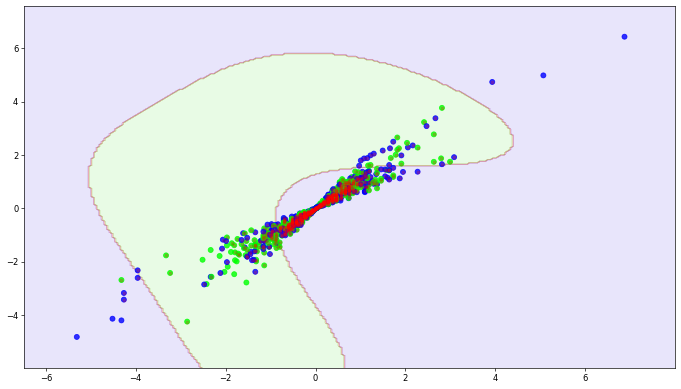

In [247]:
y_pred = svm_clf.predict(x_grid).reshape(x1_grid.shape)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), dpi=60)

s = [20*4**n for n in range(svm_clf.support_vectors_.shape[0])]

# Plot contour showing decision boundaries
plt.contourf(x1_grid, x2_grid, y_pred, cmap=plt.cm.brg, alpha=0.1)

# Plot actual data
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train.ravel(), cmap=plt.cm.brg, alpha=0.8)

# Plot support vectors
plt.scatter(svm_clf.support_vectors_[:, 0], svm_clf.support_vectors_[:, 1], s=12, color="red", alpha=0.2)

## B.2) Optimise hyperparameters

**NOTE:** Task of identifying how to reduce missclassification has been shifted to B.1, further in notebook, as I felt \
this was more tied into how to analyse classifier performance and adjust thresholds etc.

In [221]:
param_distribution = {
    "gamma": stats.loguniform(10**-4, 10*2),
    "C": stats.loguniform(10**-2, 10*5),
}


rscv_svm = RandomizedSearchCV(
    estimator=SVC(kernel="rbf", random_state=SKLEARN_RANDOM_SEED),
    param_distributions=param_distribution,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=1,
    n_iter=10000,
    random_state=SKLEARN_RANDOM_SEED
)


In [222]:
rscv_svm.fit(X_train_scaled, y_train.ravel())

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 1340 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 2440 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 3740 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 5240 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 6940 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 8840 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 10940 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 13240 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 15740 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 18440 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 21340 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 24440 tasks

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=42,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10000, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016C73724D48>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016C7371B508>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=1)

In [248]:
print(f"""
Model with highest accuracy of {rscv_svm.best_score_:.5f} obtained with parameters
{rscv_svm.best_params_}
""")


Model with highest accuracy of 0.53212 obtained with parameters
{'C': 11.891480711874985, 'gamma': 0.03968008883060138}



In [249]:
utils.compare_dummy_clf(rscv_svm.best_score_, X_train_scaled, y_train)

Classifer, with a score of 0.53212, performs BETTER than a Dummy classifier with a score of 0.46796


In [250]:
y_pred = rscv_svm.predict(X_dev_scaled)
round(accuracy_score(y_dev, y_pred), 5)

0.49495

lower dev set accuracy

# Classifier A.3 KNN

**A.3 a)**

features already scaled, so task complete.
<br><br>
**A.3 c)**

Rather than performing an optimsation algorithm to train a model parameter, the KNN effectively "memorises" the training data \
storing the feature vector and label for each training instance, hence why it is called a "lazy" algorithm.
When it comes time to make a prediction it uses a distance metric to find the distance of the input to all training points. \
It then predict the label by using either an average (for regression) or mode (classification) of the **k** nearest points.

## A.3 b) Comparing scores with various distance metrics

Implement following metrics for comparison
+ minkowski
+ manhattan
+ mahalanobis

In [115]:
knn_minkowski = KNeighborsClassifier(n_neighbors=35, metric="minkowski", p=2)
knn_manhattan = KNeighborsClassifier(n_neighbors=35, metric="manhattan", p=1)
knn_mahalanobis = KNeighborsClassifier( n_neighbors=35, metric='mahalanobis', metric_params={'V': np.cov(X_train_scaled.T)}, n_jobs=-1)

use cross validation to get scores for each distance metric

In [189]:
knn_scores = []

for clf in [knn_minkowski, knn_manhattan, knn_mahalanobis]:
    scores = cross_val_score(clf, X_train_scaled, y_train.ravel(), cv=5, scoring="accuracy", verbose=0, n_jobs=-1)
    knn_scores.append(np.mean(scores))

In [190]:
headers = ["minkowski", "manhattan", "mahalanobis"]
table = tabulate(tabular_data=[knn_scores], headers=headers)
print(table)

  minkowski    manhattan    mahalanobis
-----------  -----------  -------------
    0.55869     0.534063       0.505057


## B.2) Optimise hyperparameters

**NOTE:** Task of identifying how to reduce missclassification has been shifted to B.1, further in notebook, as I felt \
this was more tied into how to analyse classifier performance and adjust thresholds etc.

In [229]:
param_distribution = {
    "n_neighbors": stats.randint(2, 100),
}


rscv_knn = RandomizedSearchCV(
    estimator=KNeighborsClassifier(metric="minkowski", p=2),
    param_distributions=param_distribution,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=1,
    n_iter=1000,
    random_state=SKLEARN_RANDOM_SEED
)

In [230]:
rscv_knn.fit(X_train_scaled, y_train.ravel())

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1980 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 3080 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 4380 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   10.8s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='deprecated', n_iter=1000, n_jobs=-1,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016C75050BC8>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=1)

In [231]:
print(f"""
Model with highest accuracy of {rscv_knn.best_score_:.5f} obtained with parameters
{rscv_knn.best_params_}
""")


Model with highest accuracy of 0.53091 obtained with parameters
{'n_neighbors': 5}



In [251]:
utils.compare_dummy_clf(rscv_knn.best_score_, X_train_scaled, y_train)

Classifer, with a score of 0.53091, performs BETTER than a Dummy classifier with a score of 0.46796


In [252]:
y_pred = rscv_knn.predict(X_dev_scaled)
round(accuracy_score(y_dev, y_pred), 5)

0.55556

KNN does better on the dev set than the training set. Might be underfitting.

# B.1 Prediction Quality Investigation

First I will analyse 1 classifier using various methods. \
These were then converted to methods moved into "utils.py", from there we can more quickly analyse multiple classifiers and \
present summary statistics in a dataframe for ease of comparison

In [393]:
knn = rscv_knn.best_estimator_
svm = rscv_svm.best_estimator_
log = rscv_log.best_estimator_

## Confusion Matrix

In [394]:
conf_mx_log, y_train_pred_log = utils.get_confusion_matrix(log, X_train_scaled, y_train.ravel(), cv=5)
conf_mx_svm, y_train_pred_svm = utils.get_confusion_matrix(svm, X_train_scaled, y_train.ravel(), cv=5)
conf_mx_knn, y_train_pred_knn = utils.get_confusion_matrix(knn, X_train_scaled, y_train.ravel(), cv=5)

Check that rows sum to correct label values in the below confusion matrices
+ -ve class are labels of y=0 (down moves)
+ +ve class are labels of y=1 (up moves)

In [400]:
pd.Series(y_train.ravel()).value_counts()[[0, 1]]

0    443
1    446
dtype: int64

In [405]:
from sklearn.metrics import confusion_matrix

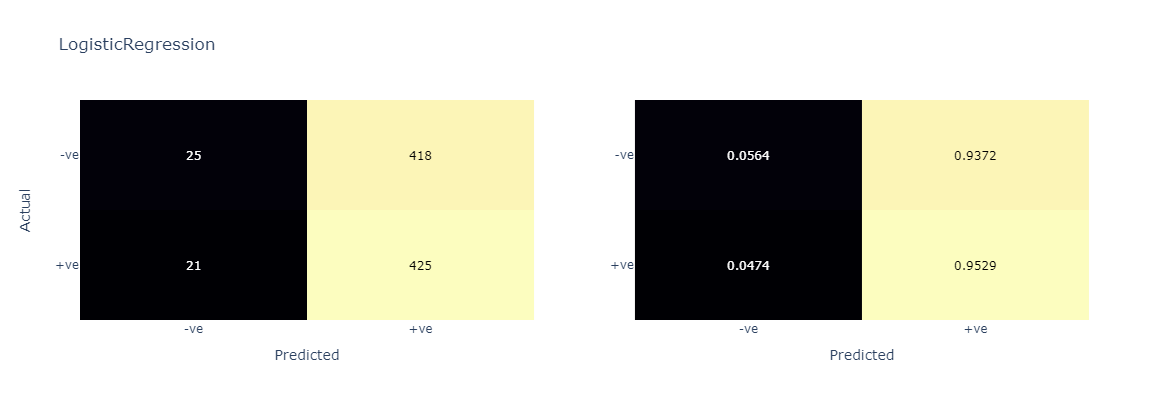

In [395]:
fig = utils.plot_confusion_matrix(conf_mx=conf_mx_log, title="LogisticRegression"); fig.show()

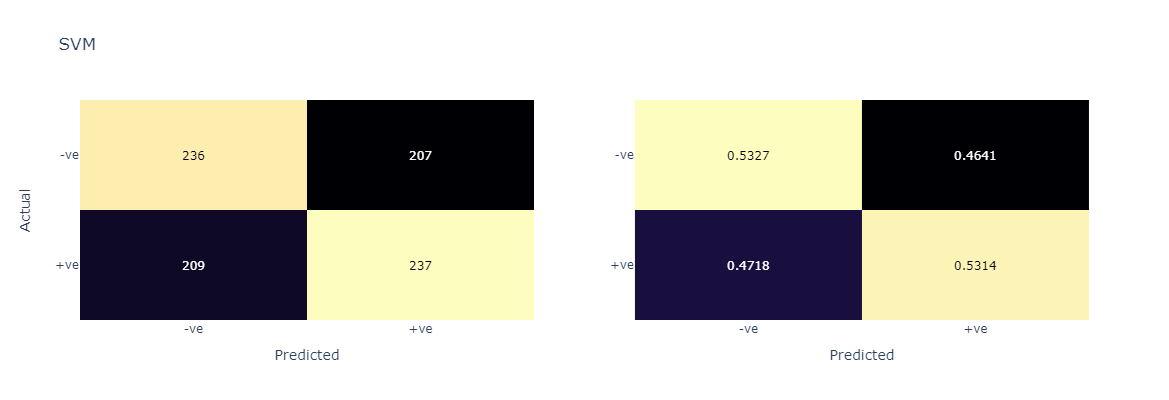

In [396]:
fig = utils.plot_confusion_matrix(conf_mx=conf_mx_svm, title="SVM"); fig.show()

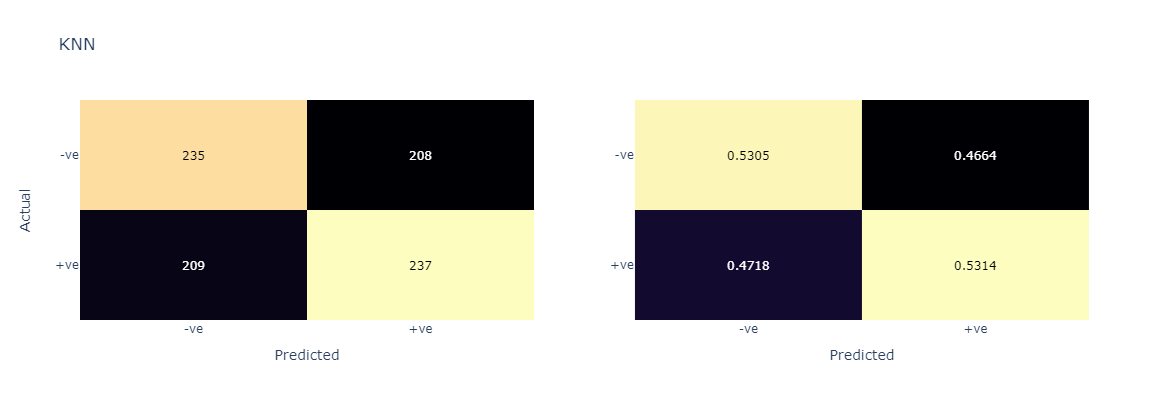

In [397]:
fig = utils.plot_confusion_matrix(conf_mx=conf_mx_knn, title="KNN"); fig.show()

## Precision and Recall

+ Precision \
accuracy of +ve **predictions**\
out of TP+FP +ve class **predictions**, TP of them were **actually** +ve class \
$$
Precision = \frac{TP}{TP + FP}
$$
<br><br>
+ Recall \
ratio of **actual** +ve instances that are correctly predicted by classifer. \
out of TP + FN (total of **actual** +ve classes) TP of them were correctly predicted as +ve
$$
Recall = \frac{TP}{TP + FN}
$$

Increasing precision reduces recall and vice versa
+ increasing threshold increases precision (usually) and reduces recall
+ decreasing threshold reduces precision (usually) and increases recall

In [366]:
TN, FP = conf_mx_knn[0, 0], conf_mx_knn[0, 1]
FN, TP = conf_mx_knn[1, 0], conf_mx_knn[1, 1]

headers = ["TP", "TN", "FP", "FN"]
tabular_data = [[TP, TN, FP, FN]]
table = tabulate(tabular_data, headers)
print(table)

  TP    TN    FP    FN
----  ----  ----  ----
 237   235   208   209


In [260]:
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score

**Precision/Accuracy of positive classes (up moves)**

In [406]:
f"{round(TP/(TP+FP), 5)*100} %" # same result from precision_score(y_train.ravel(), y_train_pred_knn)

'53.258 %'

**Recall/Sensitivity of Positive Class (up moves)**

Recall is also know as the Sensitivity or True Positive Rate (TPR). \
This is the ratio of postitive instances that are correctly detected by the classifier

In [298]:
f"{round(TP/(TP+FN), 5)*100} %" # same result from recall_score(y_train.ravel(), y_train_pred_knn)

('73.538 %', 0.7353760445682451)

**True Negative Rate** (TNR) or **specificity**\
ratio of negative instances that are correctly classified as negative (TN)
<br>
$$
TNR = \frac{TN}{TN+FP}
$$
<br><br>

In [299]:
f"{round(TN/(TN+FP), 5)*100} %"

'36.747 %'

**False Positive Rate** (FPR)
<br>
ratio of negative instances that are incorrectly classified as positive (FP)
<br>
$$
FPR = 1 - TNR
$$
<br><br>
$$
FPR = \frac{FP}{TN+FP}
$$

In [300]:
f"{round(FP/(TN+FP), 5)*100} %"

'63.253 %'

In [408]:
# Across all classifiers
conf_matricies = [conf_mx_log, conf_mx_svm, conf_mx_knn]
headers = ["log", "svm", "knn"]
series_list = []

for conf_mx, name in zip(conf_matricies, headers):
    TN, FP = conf_mx[0, 0], conf_mx[0, 1]
    FN, TP = conf_mx[1, 0], conf_mx[1, 1]
    
    precision = round(TP / (TP + FP), 5)
    recall = round(TP/ (TP + FN), 5)
    
    tnr = round(TN / (TN + FP), 5)
    
    fpr = round(FP / (TN+FP), 5)
    series = pd.Series({"precision":precision, "recall":recall, "TNR": tnr, "FPR":fpr}, name=name)
    series_list.append(series)

df_quality = pd.DataFrame(series_list)
df_quality

,precision,recall,TNR,FPR
log,0.50415,0.95291,0.05643,0.94357
svm,0.53378,0.53139,0.53273,0.46727
knn,0.53258,0.53139,0.53047,0.46953


In [333]:
y_pred_knn = cross_val_predict(knn, X_train_scaled, y_train.ravel(), cv=5)
y_proba_knn = cross_val_predict(knn, X_train_scaled, y_train.ravel(), cv=5, method="predict_proba")
y_proba_knn.shape, y_pred_knn.shape

((889, 2), (889,))

In [334]:
i =2
y_pred_knn[i], y_proba_knn[i, :], y_train[i]

(1, array([0.2, 0.8]), 0)

It appears the first column is the probability of y=0 and second column is probability y=1

In [335]:
up_move_scores = y_proba_knn[:, 1]  # set up move as positive class
down_move_scores = y_proba_knn[:, 0] # set down move as positive class

In [336]:
from sklearn.metrics import precision_recall_curve

precisions_up, recalls_up, thresholds_up = precision_recall_curve(y_train, up_move_scores)
precisions_down, recalls_down, thresholds_down = precision_recall_curve(y_train, down_move_scores)

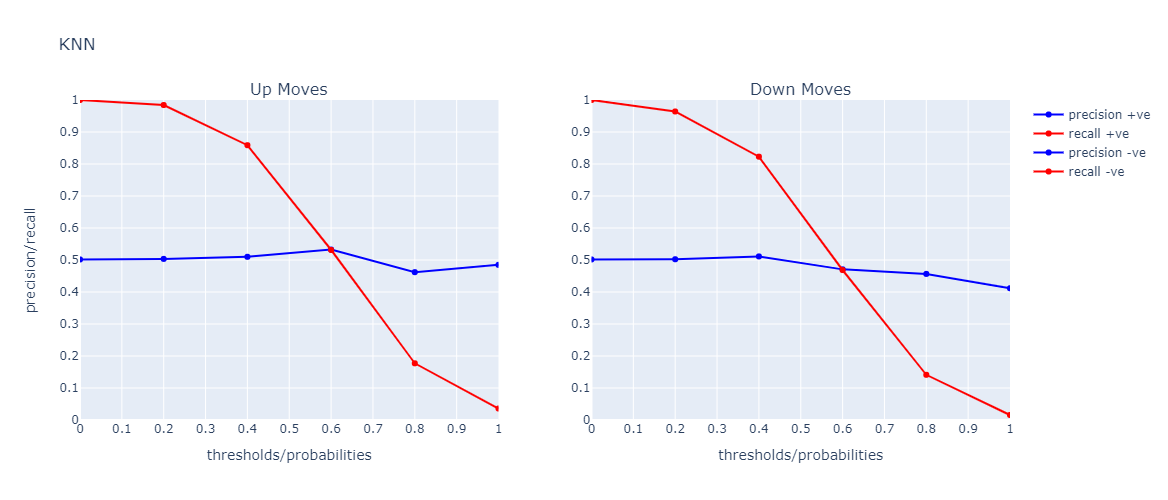

In [339]:
from scipy.interpolate import interp1d

def plot_precision_recall_vs_proba(precisions_up, recalls_up, thresholds_up, precisions_down, recalls_down, thresholds_down, ranges=[0, 1], title=None):
    
    fig = make_subplots(rows=1, cols=2, column_titles=["Up Moves", "Down Moves"])
    
    trace1a = go.Scatter(x=thresholds_up, y=precisions_up, name="precision +ve", marker=dict(color="blue"))
    trace1b = go.Scatter(x=thresholds_up, y=recalls_up, name="recall +ve", marker=dict(color="red"))
    
    trace2a = go.Scatter(x=thresholds_down, y=precisions_down, name="precision -ve", marker=dict(color="blue"))
    trace2b = go.Scatter(x=thresholds_down, y=recalls_down, name="recall -ve", marker=dict(color="red"))
    
    fig.add_trace(trace1a, row=1, col=1)
    fig.add_trace(trace1b, row=1, col=1)
    
    fig.add_trace(trace2a, row=1, col=2)
    fig.add_trace(trace2b, row=1, col=2)
    
    fig.update_layout(height=500, width=1000,
                      title=title, showlegend=True
                     )
    
    tick_kwargs = {
        'tickmode':'linear', 
        'tick0':0,
        'dtick':0.1
    }
    fig.update_xaxes(title_text="probabilities", range=ranges, row=1, col=1, **tick_kwargs)
    fig.update_xaxes(title_text="probabilities", range=ranges, row=1, col=2, **tick_kwargs)
    
    
    fig.update_yaxes(title_text="precision/recall", range=ranges, row=1, col=1, **tick_kwargs)
    fig.update_yaxes(range=ranges, row=1, col=2, **tick_kwargs)
    fig.show()
    
plot_precision_recall_vs_proba(precisions_up, recalls_up, thresholds_up, precisions_down, recalls_down, thresholds_down, ranges=[0, 1], title="KNN")

recall is usually a smooth curve that goes down with increasing threshold. 

In [360]:
def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds, title=None):
    
    fig = go.Figure()
    
    trace1a = go.Scatter(x=thresholds, y=precisions, name="precision", marker=dict(color="blue"))
    trace1b = go.Scatter(x=thresholds, y=recalls, name="recall", marker=dict(color="red"))
    
    fig.add_trace(trace1a)
    fig.add_trace(trace1b)
    
    fig.update_layout(height=500, width=1000,
                      title=title, showlegend=True
                     )
    
#     tick_kwargs = {
#         'tickmode':'linear', 
#         'tick0':0,
#         'dtick':0.1
#     }

    fig.update_xaxes(title_text="thresholds")
    fig.update_yaxes(title_text="precision/recall", range=[0, 1], dtick=0.1)
    
    fig.show()

In [356]:
y_decision_svm = cross_val_predict(svm, X_train_scaled, y_train.ravel(), cv=5, method="decision_function")

With positive class as 1

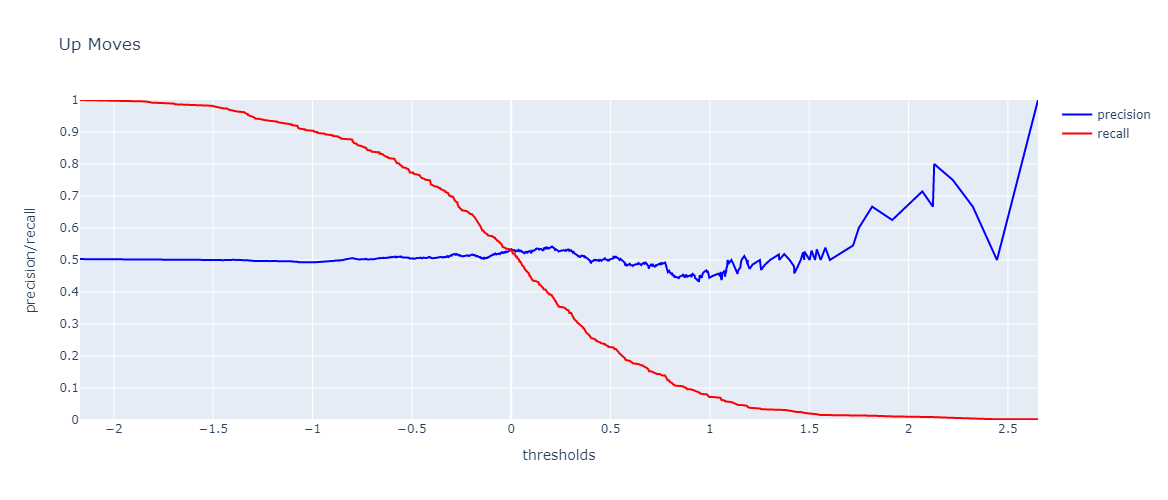

In [363]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_decision_svm, pos_label=1)
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds, title="Up Moves")

With positive class as 0

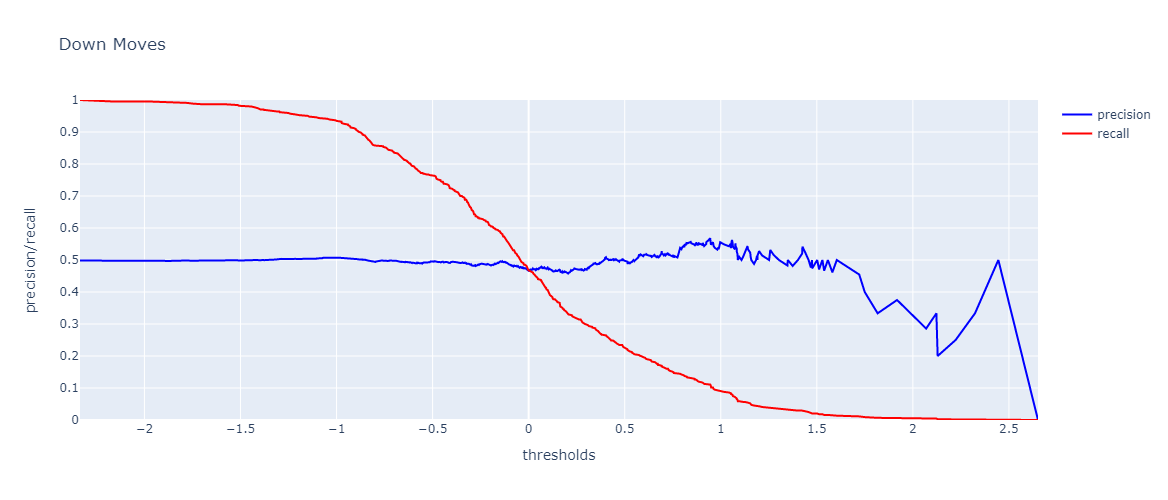

In [364]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_decision_svm, pos_label=0)
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds, title="Down Moves")

## ROC

`roc_curve(...)` expects **scores** from a decision function. However we can also pass in class probabilities. \
In this case a binary classifier will have 2 columns, one for each class. \
We pass in the probabilities for the class that we want the `roc_curve(..)` to treat as the **positive class**

In [330]:
from sklearn.metrics import roc_curve

fpr_up, tpr_up, thresholds_up = roc_curve(y_train, up_move_scores)
fpr_down, tpr_down, thresholds_down = roc_curve(y_train, up_move_scores)

Is there a way to make a good precision/recall tradeoff?

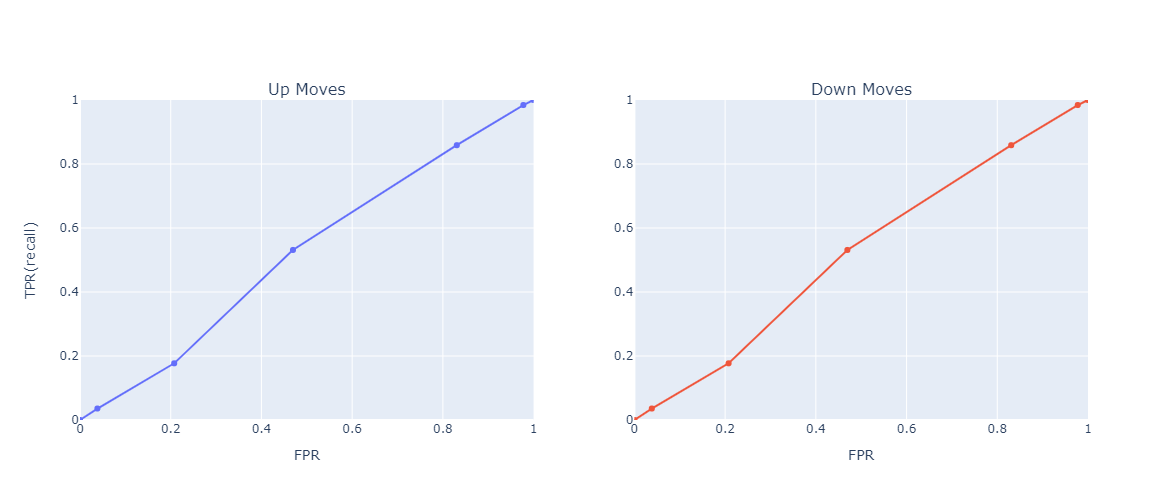

In [331]:
from plotly.subplots import make_subplots


def plot_roc_curve(fpr1, tpr1, fpr2, tpr2, title=None):
    fig = make_subplots(rows=1, cols=2, column_titles=["Up Moves", "Down Moves"])
    
    trace1 = go.Scatter(x=fpr1, y=tpr1)
    trace2 = go.Scatter(x=fpr2, y=tpr2)
    
    fig.add_trace(trace1, row=1, col=1)
    fig.add_trace(trace1, row=1, col=2)
    
    #fig = px.line(x=fpr, y=tpr, width=500, height=500)
    fig.update_layout(height=500, width=1000,
        xaxis=dict(title="fpr", range=[0, 1]),
        yaxis=dict(title="TPR(recall)", range=[0, 1]),
        title=title, showlegend=False
    )
    fig.update_xaxes(title_text="FPR", range=[0, 1], row=1, col=1)
    fig.update_xaxes(title_text="FPR", range=[0, 1], row=1, col=2)
    
    
    fig.update_yaxes(title_text="TPR(recall)", range=[0, 1], row=1, col=1)
    fig.update_yaxes(range=[0, 1], row=1, col=2)
    fig.show()
    
plot_roc_curve(fpr_up, tpr_up, fpr_down, tpr_down)

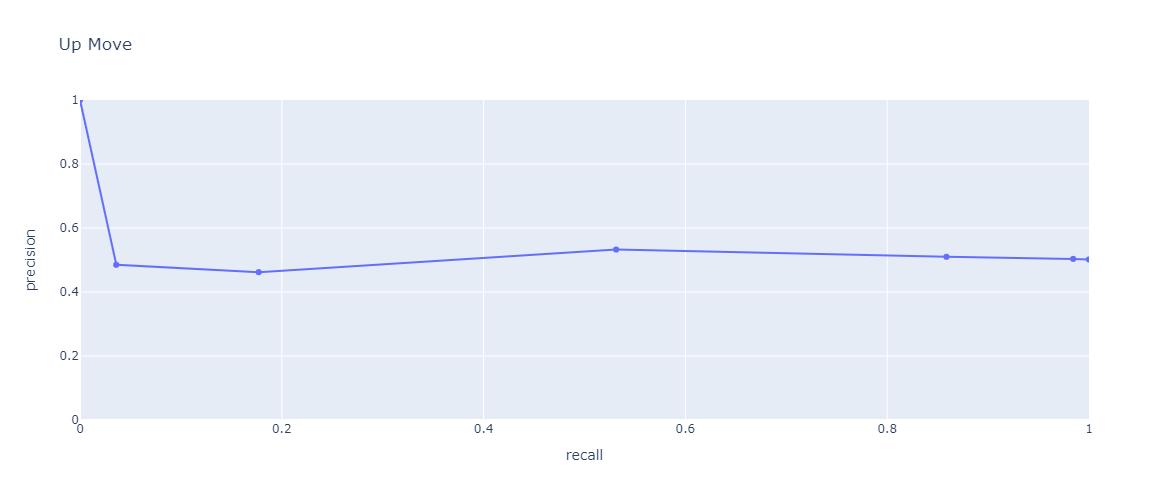

In [295]:
def plot_recall_vs_precision(precisions_up, recalls_up, precisions_down, recalls_down, title=None):
    # Use recall on X axis since it is smoother and goes down with increasing threshold
    trace1 = go.Scatter(x=recalls_up, y=precisions_up)
    trace1 = go.Scatter(x=recalls_down, y=precisions_down)
    
    fig = go.Figure(data=[t])
    
    fig.update_layout(height=500, width=500,
        xaxis=dict(title="recall", range=[0, 1]),
        yaxis=dict(title="precision", range=[0, 1]),
        title=title
    )
    fig.show()
    
plot_recall_vs_precision(precisions_up, recalls_up, "Up Move")

In [ ]:
def plot_recall_vs_precision(precisions_up, recalls_up, precisions_down, recalls_down, title=None):
    fig = make_subplots(rows=1, cols=2, column_titles=["Up Moves", "Down Moves"])
    
    # Use recall on X axis since it is smoother and goes down with increasing threshold
    trace1 = go.Scatter(x=recalls_up, y=precisions_up)
    trace2 = go.Scatter(x=recalls_down, y=precisions_down)
    
    fig.add_trace(trace1, row=1, col=1)
    fig.add_trace(trace1, row=1, col=2)
    
    fig.update_layout(height=500, width=1000,
        xaxis=dict(title="fpr", range=[0, 1]),
        yaxis=dict(title="TPR(recall)", range=[0, 1]),
        title=title, showlegend=False
    )
    fig.update_xaxes(title_text="recall", range=[0, 1], row=1, col=1)
    fig.update_xaxes(title_text="recall", range=[0, 1], row=1, col=2)
    
    a
    fig.update_yaxes(title_text="precision", range=[0, 1], row=1, col=1)
    fig.update_yaxes(range=[0, 1], row=1, col=2)
    fig.show()
    fig.show()
    
plot_recall_vs_precision(precisions_up, recalls_up, "Up Move")

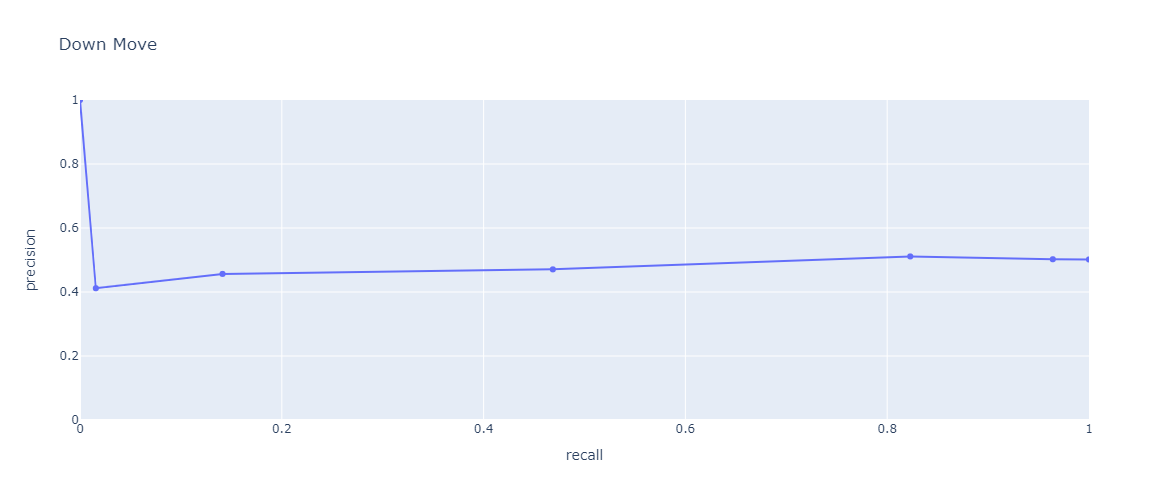

In [296]:
plot_recall_vs_precision(precisions_down, recalls_down, "Down Move")

In [297]:
fpr_up, tpr_up, thresholds_up = roc_curve(y_train, up_move_scores)
fpr_down, tpr_down, thresholds_down = roc_curve(y_train, down_move_scores)

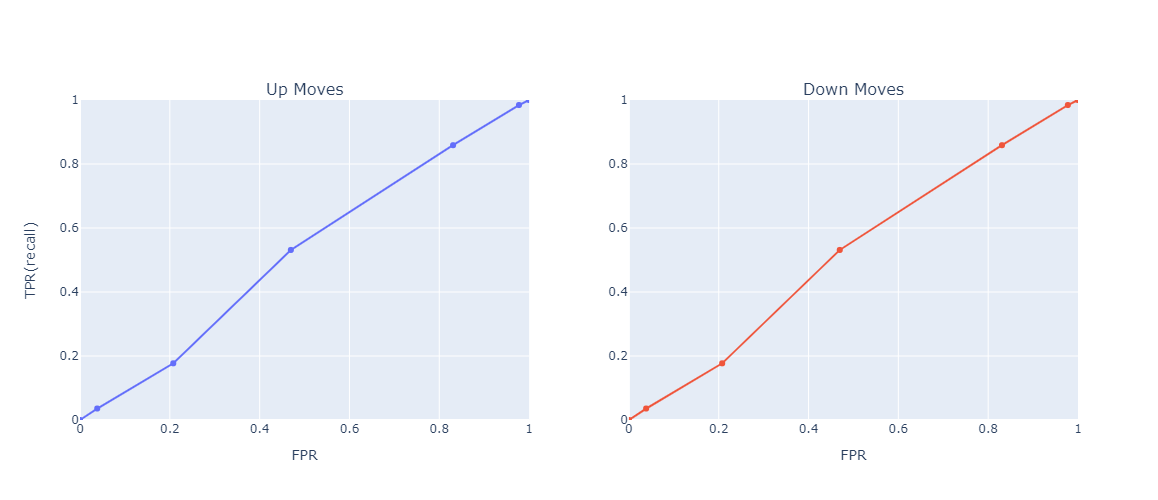

In [309]:
from plotly.subplots import make_subplots


def plot_roc_curve(fpr1, tpr1, fpr2, tpr2, title=None):
    fig = make_subplots(rows=1, cols=2, column_titles=["Up Moves", "Down Moves"])
    
    trace1 = go.Scatter(x=fpr1, y=tpr1)
    trace2 = go.Scatter(x=fpr2, y=tpr2)
    
    fig.add_trace(trace1, row=1, col=1)
    fig.add_trace(trace1, row=1, col=2)
    
    #fig = px.line(x=fpr, y=tpr, width=500, height=500)
    fig.update_layout(height=500, width=1000,
        xaxis=dict(title="fpr", range=[0, 1]),
        yaxis=dict(title="TPR(recall)", range=[0, 1]),
        title=title, showlegend=False
    )
    fig.update_xaxes(title_text="FPR", range=[0, 1], row=1, col=1)
    fig.update_xaxes(title_text="FPR", range=[0, 1], row=1, col=2)
    
    
    fig.update_yaxes(title_text="TPR(recall)", range=[0, 1], row=1, col=1)
    fig.update_yaxes(range=[0, 1], row=1, col=2)
    fig.show()
    
plot_roc_curve(fpr_up, tpr_up, fpr_down, tpr_down)

ROC AUC \
`roc_auc_score(...)` - returns area under the curve of the fpr plotteed against the tpr

In [300]:
roc_auc_score(y_train, up_move_scores)

0.5201312899209426

In [301]:
roc_auc_score(y_train, down_move_scores)

0.4798687100790574

Ability to capture down moves is worse than a dummy classifier